In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

# Specify data folder
data_folder = '/app/data'

# Load the dataset
data_sv_dict = util.split_by_field(util.load_cmapss_data(data_folder), field='src')
data = data_sv_dict['train_FD004']
# Define input folders
dt_in = list(data.columns[3:-1])
# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = data.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]
# Split datasets
tr, ts = util.partition_by_machine(data, tr_mcn)
# Rescale
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)
# Load pre-trained model
nn = keras.models.load_model("rul_regressor")
# Obtain the predictions
tr_pred = nn.predict(tr_s[dt_in]).ravel() * nparams['trmaxrul']
ts_pred = nn.predict(ts_s[dt_in]).ravel() * nparams['trmaxrul']

# ...And Optimize

'Cause we are not just dealing with ML, ain't we?

## Our Current Situation

**The results so far are not comforting**

...But it's worth seeing what is going on _over time_

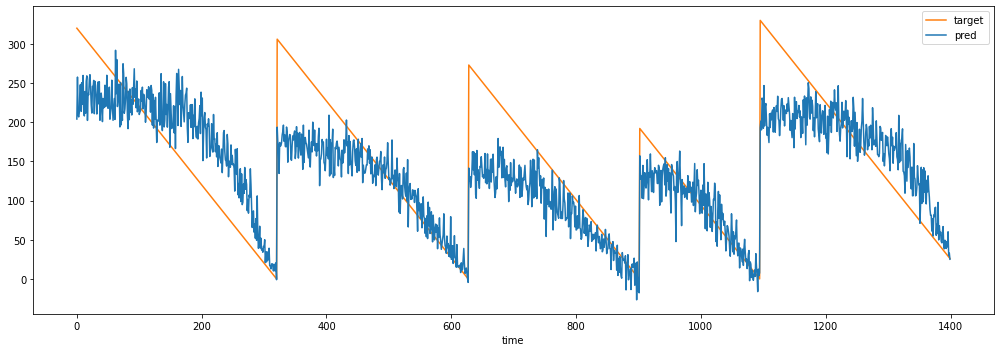

In [2]:
stop = 1400
util.plot_rul(tr_pred[:stop], tr['rul'][:stop], figsize=figsize)

...And we get the same shapes also on the validation and test set 

## ...And Two Observations about It

* All sequeces of predicted RULs start with a "flat" section
* ...And after a while they bend and start decreasing

> **First: why is this happening? And why is is so consistent?**

**One reason is that _large RUL values_ are under-represented**

...Since not all machines run for the same time

* As a result we will have _larger noise_
* ...And it may be impossible to predict RULs larger than in the training set

However, the curve bend relatively late

* ...And therefore there must be something more

## ...And Two Observations about It

* All sequeces of predicted RULs start with a "flat" section
* ...And after a while they bend and start decreasing

> **First: why is this happening? And why is is so consistent?**

**The main reason is that degradation _does not start immediately_**

...But typically only when microscopic defects grow to become perceivable

* As a result, early on the NN will be "see" examples with _comparable input_
* ...But _different target_ values

When an MSE loss, the optimal choice in this case is to predict the _average_

## ...And Two Observations about It

* All sequeces of predicted RULs start with a "flat" section
* ...And after a while they bend and start decreasing

> **Second: is this pattern good or bad news for us?**

**Our goal is _not_ to regress RUL values with high accuracy**

...But rather to define a maintenance _policy_ in the form:

$$
f(x, \omega) < \theta \ \Rightarrow \text{ trigger maintenance}
$$

* For this, we just need to _stop at the right time_
* ...And our model may be accurate enough in the region that matters

## Threshold Calibration as an Optimization Problem

**Given a RUL estimator**

...We can choose when to trigger maintenance by calibrating $\theta$

* This is in fact an(ohter) _optimization problem_
* ...And to formulate it we need a _cost function_

**Our cost function will rely on this simplified cost model:**

* Whenever a turbine _operates_ for a time step, we gain a _profit_ of 1 unit
* A failure costs $C$ units (i.e. the equivalent of $C$ operation days)
* We never trigger maintenance before $s$ time steps

Some comments:

* $C$ is actually an offset over the cost of maintenance
* The last rule mimics using preventive maintenance as a fail-safe mechanism

## The Cost Function

**Let $x_k$ be the times series for machine $k$ (out of $n_r$), and $n_t$ its length**

With our RUL based policy:

* Given a cost function $\mathit{cost}(f(x_k), {x_k}, \theta)$ for one machine, the total cost is:

$$
\sum_{k = 1}^{n_r} \mathit{cost}(f(x_k), {x_k}, \theta)
$$

* The time step when we trigger maintenance is given by:

$$
\min \{i = 1.. n_t \mid f(x_{ki}) < \theta\}
$$

* A failure occurs if:

$$
f(x_{ki}) \geq \theta \quad \forall i = 1 .. n_t
$$

## The Cost Function

**The cost formula _for a single machine_ will be:**

$$
\mathit{cost}(f(x_k), {x_k}, \theta) = \mathit{op\_profit}(f(x_k), \theta) + \mathit{fail\_cost}(f(x_k), \theta)
$$

Where:

$$
\mathit{op\_profit}(f(x_k), \theta) = -\max(0, \min \{i \in I_k \mid f(x_{ki}) < \theta\}-s) \\
\mathit{fail\_cost}(f(x_k), \theta) = \left\{
\begin{align}
& C \text{ if } f(x_{ki}) \geq \theta \quad \forall i \in I_k \\
& 0 \text{ otherwise}
\end{align}
\right.
$$

* $s$ units of machine operation are guaranteed
* ...So we gain over the default policy only if we stop after that
* Profit is modeled as a negative cost

## The Cost Function

**Normally, we would determine $s$ and $C$ by talking to a domain expert**

...In our case wi well pick reasonable values based on our data

* First, we collect all failure times:

In [3]:
tr_failtimes = tr.groupby('machine')['cycle'].max()

* Then, we define $s$ and $C$ based on statistics:

In [4]:
safe_interval = tr_failtimes.min()
maintenance_cost = tr_failtimes.max()

* For the safe interval $s$, we choose the minimum failure time
* For the maintenance cost $C$ we choose the largest failure time

We are taling about jet engines, so failing is BAD

## Calibration and Policy Definition Problem

**Our calibration problem is then in the form:**

$$
\text{argmin}_\theta \sum_{k = 1}^{n_r} \mathit{cost}(f(x_k), {x_k}, \theta)
$$

* If we pair it with our previous training step
* ...We obtain a formulation for the entire _policy definition_ problem:

$$
\text{argmin}_\theta \sum_{k = 1}^{n_r} \mathit{cost}(f(x_k, \omega^*), {x_k}, \theta) \\
\text{where: } \omega^* = \text{argmin}_\omega \{L(y, \hat{y}) \mid y = f(x, \omega)\}
$$

**This is how we should have started in the first place**

## Solving the Calibrarion Problem

**Solving the calibration problem is very easy:**

$$
\text{argmin}_\theta \sum_{k = 1}^{n_r} \mathit{cost}(f(x_k, \omega^*), {x_k}, \theta) \\
\text{where: } \omega^* = \text{argmin}_\omega \{L(y, \hat{y}) \mid y = f(x, \omega)\}
$$

* We need to optimize a single (scalar) variable, i.e. $\theta$
* ...And changing $\theta$ does not impact the optimal $\omega$

**This is a _univariate optimization_ problem**

* The cost function is non-differentiable
* ...But the problem is so simple that even _grid search_ will work very well

## Solving the Calibration Problem

**We can _sample a range_ of values for the $\theta$ parameter**

...Then simply pick the value with the smallest cost

* The code in `optimize_threshold` can also plot the corresponding cost surface

Optimal threshold for the training set: 3.52


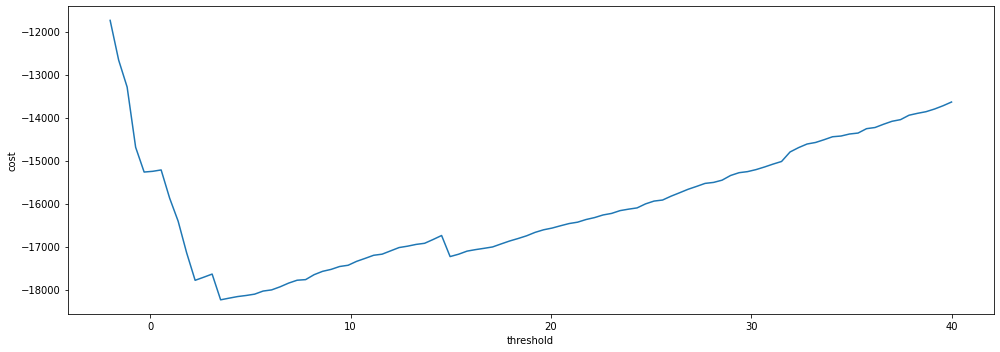

In [6]:
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.linspace(-2, 40, 100)
tr_thr = util.optimize_threshold(tr['machine'].values, tr_pred, th_range, cmodel, plot=True, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr:.2f}')

## Evaluation

**Finally, we can check how we are doing on the test set:**

In [7]:
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, tr_thr, return_margin=True)
print(f'Cost: {tr_c} (training), {ts_c} (test)')

Cost: -18238 (training), -7075 (test)


We can also evaluate the margin for improvement:

In [8]:
print(f'Avg. fails: {tr_f/len(tr_mcn):.2f} (training), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.01 (training), 0.00 (test)
Avg. slack: 15.06 (training), 11.63 (test)


* Slack = distance between when we stop and the failure
* The results are actually quite good!
* ...And we also generalize fairly well

## Some Considerations

**In principle, RUL regression is a very hard problem**

* Our linearly decreasing RUL assumption is just a rough oversimplification
* ...RUL is inherently subject to stochastisticy
* ...And depends on the how the machine _will be_ used

**But we _don't care_, since RUL prediction was _not our true problem_**

The real problem involved both _prediction and optimization_

* We had to optimize the NN parameters (to obtain good predictions)
* We had to optimize the threshold

The ultimate goal was to _reduce maintenance cost_

**Keep in mind _the big picture_**

* In a "predict, then optimize" setting
* ...Quality should be judged on the final cost